# Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
data_users = pd.read_csv('/datasets/users.csv')


In [2]:
data_calls.info()
data_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Перевести call_date в дату. duration первести int с округлением в большую сторону

In [3]:
data_internet.info()
data_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


session_date перевести в дату. mb_used перевести в количество гигабайт. Если больше 1024, то будет уже 2 гигабайта.

In [4]:
data_messages.info()
data_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Перевести message_date в дату

In [5]:
data_tariffs.info()
data_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
data_users.info()
data_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [7]:
data_users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [8]:
data_users['age'].value_counts()

53    14
42    14
63    13
71    13
64    13
73    12
21    12
40    12
39    11
47    11
29    11
26    11
37    11
41    10
36    10
58    10
45    10
70    10
52    10
51     9
27     9
48     9
50     9
28     9
30     9
24     9
20     9
19     9
56     9
23     9
68     9
66     9
65     9
69     8
62     8
60     8
44     8
55     8
25     7
43     7
67     7
35     7
74     7
32     7
31     7
46     7
75     6
54     6
59     6
18     6
33     5
34     5
38     5
22     5
72     5
49     4
57     4
61     3
Name: age, dtype: int64

In [9]:
data_users['city'].value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Иваново             1
Химки               1
Архангельск         1
Подольск            1
Нижневартовск       1
Name: city, Length: 76, dtype: int64

churn_date и reg_date перевести в дату

## Шаг 2. Подготовьте данные

Перевод колонок в дату

In [10]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')


data_calls['month'] = data_calls['call_date'].dt.month
data_internet['month'] = data_internet['session_date'].dt.month
data_messages['month'] = data_messages['message_date'].dt.month
data_users['month'] = data_users['reg_date'].dt.month

Округление гигабайт в большую сторону, а так же округление duration в большую сторону 

In [11]:
def mb(data):
    return math.ceil(data['mb_used'] / 1024)
 
data_internet['mb_used'] = data_internet.apply(mb, axis=1)
data_calls['duration'] = data_calls['duration'].apply(lambda x: math.ceil(x))

In [12]:
data_calls.info()
data_calls['duration'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
month        202607 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.7+ MB


0     39613
7     11510
6     11457
5     11411
8     11272
9     10973
4     10918
3     10362
10    10186
11     9385
2      9194
12     8448
1      8402
13     7486
14     6554
15     5505
16     4551
17     3671
18     2984
19     2411
20     1806
21     1304
22      975
23      720
24      468
25      363
26      257
27      151
28      104
29       56
30       39
31       30
32       17
33       10
35        5
34        3
36        2
37        2
38        2
Name: duration, dtype: int64

Хочу объединить данные в одную общую таблицу по пользователям и месяцам и у них. Перед этим сделаю сводные таблицы для них

Сводная таблица для звонков

In [13]:
calls_per_month = data_calls.pivot_table(index=['user_id', 'month'], 
                                         values='duration', 
                                         aggfunc='sum').reset_index()

calls_per_month.columns = ['user_id', 'month', 'duration_call']
calls_per_month.head()

,user_id,month,duration_call
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


Сводная таблица для гигабайт в месяц

In [14]:
internet_per_month = data_internet.pivot_table(index=['user_id', 'month'], 
                                         values='mb_used', 
                                         aggfunc='sum').reset_index()

internet_per_month.columns = ['user_id', 'month', 'mb_sum']
internet_per_month.head()

,user_id,month,mb_sum
0,1000,5,4
1,1000,6,49
2,1000,7,28
3,1000,8,27
4,1000,9,26


Сводная таблица для сообщений в месяц

In [15]:
data_messages['count'] = 1
masseges_per_month = data_messages.pivot_table(index=['user_id', 'month'],
                                              values='count',
                                              aggfunc='sum').reset_index()

masseges_per_month.columns = ['user_id', 'month', 'masseges_sum']
masseges_per_month.head()

,user_id,month,masseges_sum
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [16]:
masseges_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
user_id         2717 non-null int64
month           2717 non-null int64
masseges_sum    2717 non-null int64
dtypes: int64(3)
memory usage: 63.8 KB


In [17]:
user_fil = data_users[['user_id', 'tariff', 'city']]
data = (calls_per_month.merge(internet_per_month, how='left', on=['user_id', 'month'])
       .merge(masseges_per_month, how='left', on=['user_id', 'month'])
       .merge(user_fil, on='user_id', how='left')
       )

data.head()

,user_id,month,duration_call,mb_sum,masseges_sum,tariff,city
0,1000,5,159,4.0,22.0,ultra,Краснодар
1,1000,6,172,49.0,60.0,ultra,Краснодар
2,1000,7,340,28.0,75.0,ultra,Краснодар
3,1000,8,408,27.0,81.0,ultra,Краснодар
4,1000,9,466,26.0,57.0,ultra,Краснодар


In [18]:
data['tariff'].value_counts()

smart    2223
ultra     951
Name: tariff, dtype: int64

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 7 columns):
user_id          3174 non-null int64
month            3174 non-null int64
duration_call    3174 non-null int64
mb_sum           3163 non-null float64
masseges_sum     2678 non-null float64
tariff           3174 non-null object
city             3174 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 198.4+ KB


In [20]:
data.query('mb_sum.isna()')

,user_id,month,duration_call,mb_sum,masseges_sum,tariff,city
1697,1273,5,220,NaN,21.0,ultra,Курган
1698,1273,6,230,NaN,38.0,ultra,Курган
1699,1273,7,253,NaN,37.0,ultra,Курган
1700,1273,8,253,NaN,41.0,ultra,Курган
1701,1273,9,223,NaN,32.0,ultra,Курган
1702,1273,10,315,NaN,35.0,ultra,Курган
1703,1273,11,272,NaN,29.0,ultra,Курган
1704,1273,12,260,NaN,39.0,ultra,Курган
2358,1377,2,179,NaN,2.0,ultra,Брянск
2471,1392,2,13,NaN,3.0,ultra,Челябинск


Перед тем как помесячную выручку для пользователей по месяцам я бы хотел заполнить пропуски в некоторых месяцах на 0, так как очевидно, что они не используются

In [21]:
data['mb_sum'] = data['mb_sum'].fillna(value=0)
data['masseges_sum'] = data['masseges_sum'].fillna(value=0)


Так же после объеденения таблиц поменялся тип данных. Для дальшейних вычислений поменяю типы 

In [22]:
data['mb_sum'] = data['mb_sum'].astype('int')
data['masseges_sum'] = data['masseges_sum'].astype('int')

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 7 columns):
user_id          3174 non-null int64
month            3174 non-null int64
duration_call    3174 non-null int64
mb_sum           3174 non-null int64
masseges_sum     3174 non-null int64
tariff           3174 non-null object
city             3174 non-null object
dtypes: int64(5), object(2)
memory usage: 198.4+ KB


Теперь посчитаем помесячную выгоду для каждого пользователя

In [24]:
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [25]:
data_tariffs['mb_per_month_included'] = data_tariffs['mb_per_month_included'] / 1024
data_tariffs['mb_per_month_included'] = data_tariffs['mb_per_month_included'].astype('int')
data_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


In [26]:
data_tariffs.loc[1]

messages_included         1000
mb_per_month_included       30
minutes_included          3000
rub_monthly_fee           1950
rub_per_gb                 150
rub_per_message              1
rub_per_minute               1
tariff_name              ultra
Name: 1, dtype: object

In [27]:
def income(row):
    count = 0
    if row['tariff'] == 'ultra': 
        df_loc = data_tariffs.loc[1]
        
        count += df_loc['rub_monthly_fee']
        call = int(row['duration_call'] - df_loc['minutes_included'])
        mb = int(row['mb_sum'] - df_loc['mb_per_month_included'])
        msg = int(row['masseges_sum'] - df_loc['messages_included'])
        
        if call > 0: count += call
        if mb > 0: count += mb * df_loc['rub_per_gb']
        if msg > 0: count += msg
    else:
        df_loc = data_tariffs.loc[0]
        
        count += df_loc['rub_monthly_fee']
        call = int(row['duration_call'] - df_loc['minutes_included'])
        mb = int(row['mb_sum'] - df_loc['mb_per_month_included'])
        msg = int(row['masseges_sum'] - df_loc['messages_included'])

        if call > 0: count += call * df_loc['rub_per_message']
        if mb > 0: count += mb * df_loc['rub_per_gb']
        if msg > 0: count += msg * df_loc['rub_per_minute']
    
    return count
        
data['income'] = data.apply(income, axis=1)

data.head()

,user_id,month,duration_call,mb_sum,masseges_sum,tariff,city,income
0,1000,5,159,4,22,ultra,Краснодар,1950
1,1000,6,172,49,60,ultra,Краснодар,4800
2,1000,7,340,28,75,ultra,Краснодар,1950
3,1000,8,408,27,81,ultra,Краснодар,1950
4,1000,9,466,26,57,ultra,Краснодар,1950


In [28]:
data_smart = data.query('tariff == "smart"')

In [29]:
data_ultra = data.query('tariff == "ultra"')

In [30]:
data_smart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 8 to 3173
Data columns (total 8 columns):
user_id          2223 non-null int64
month            2223 non-null int64
duration_call    2223 non-null int64
mb_sum           2223 non-null int64
masseges_sum     2223 non-null int64
tariff           2223 non-null object
city             2223 non-null object
income           2223 non-null int64
dtypes: int64(6), object(2)
memory usage: 156.3+ KB


In [31]:
data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 951 entries, 0 to 3150
Data columns (total 8 columns):
user_id          951 non-null int64
month            951 non-null int64
duration_call    951 non-null int64
mb_sum           951 non-null int64
masseges_sum     951 non-null int64
tariff           951 non-null object
city             951 non-null object
income           951 non-null int64
dtypes: int64(6), object(2)
memory usage: 66.9+ KB


Исходя из предобработки данных у нас получилась таблица по 12 месяцев у каждого пользователя количества расходованных минут, смс, интернета.А так же какой тариф использует пользователь, и с какого он города

## Шаг Проанализируйте данные

Построим гистограммы по количеству звонков

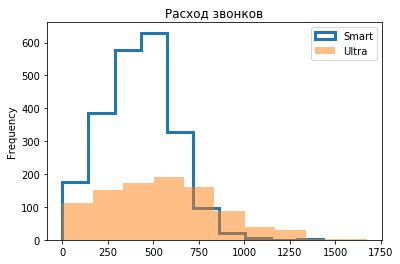

In [32]:
ax = (data_smart
     .plot(
         kind='hist',
         y='duration_call',
         histtype='step',
         linewidth=3,
         legend=True,
         label='Smart'))

(data_ultra.plot(kind='hist', 
                 y='duration_call',
                 ax=ax,
                 alpha=0.5,
                 legend=True,
                 label='Ultra',
                 title='Расход звонков'));

Расчет средних значений, дисперсии и среднего отклонения в количестве звонков

In [33]:
data.pivot_table(index='tariff',
                 values='duration_call',
                 aggfunc=['mean','var', 'std'])

,mean,var,std
,duration_call,duration_call,duration_call
tariff,,,
smart,419.062978,35844.189551,189.325618
ultra,545.451104,94203.418396,306.925754


Судя по гистограмме данные смещенны влево у обоих тарифов, но средние значения у них конечно же разнятся, что видно по таблице. Что касается дисперсии то тут так же очень большая разница, и я бы отсек значения больше 1000 минут в месяц так как они могут повлиять на проверку гипотез. В целом проверю потом и так и так

Гистограмма по расходу интернета

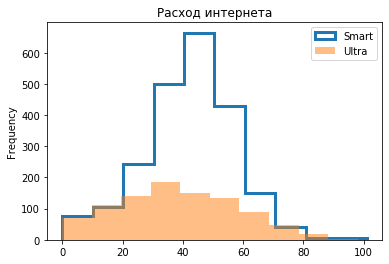

In [34]:
ax = (data_smart
     .plot(
         kind='hist',
         y='mb_sum',
         histtype='step',
         linewidth=3,
         legend=True,
         label='Smart'))

(data_ultra.plot(kind='hist', 
                 y='mb_sum',
                 ax=ax,
                 alpha=0.5,
                 legend=True,
                 label='Ultra',
                 title='Расход интернета'));

Расчет средних значений, дисперсии и среднего отклонения в расходованного интернета

In [35]:
data.pivot_table(index='tariff',
                 values='mb_sum',
                 aggfunc=['mean','var', 'std'])

,mean,var,std
,mb_sum,mb_sum,mb_sum
tariff,,,
smart,42.417904,223.697915,14.956534
ultra,38.135647,383.923686,19.593971


Что касается количества используемого интернета я бы так и оставил, потому что не вижу какого-то сильного отклонения. Возможно есть в правую сторону у тарифа ultra, но для проверки гипотезы так всё оставил бы.

Гистограмма по расходу смс

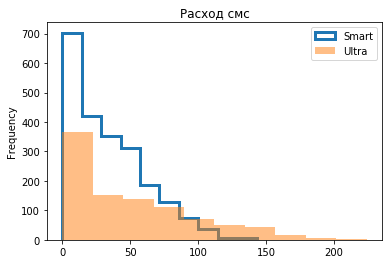

In [36]:
ax = (data_smart
     .plot(
         kind='hist',
         y='masseges_sum',
         histtype='step',
         linewidth=3,
         legend=True,
         label='Smart'))

(data_ultra.plot(kind='hist', 
                 y='masseges_sum',
                 ax=ax,
                 alpha=0.5,
                 legend=True,
                 label='Ultra',
                 title='Расход смс'));

Расчет средних значений, дисперсии и среднего отклонения в отправленных сообщениях

In [37]:
data.pivot_table(index='tariff',
                 values='masseges_sum',
                 aggfunc=['mean','var', 'std'])

,mean,var,std
,masseges_sum,masseges_sum,masseges_sum
tariff,,,
smart,33.396311,798.595792,28.259437
ultra,49.033649,2198.733603,46.890656


Что касается смс то тут распределение отклонено вправо, и видна большая дисперсия у тарифа ultra, но оно всё не выходит за рамки бесплатной части.

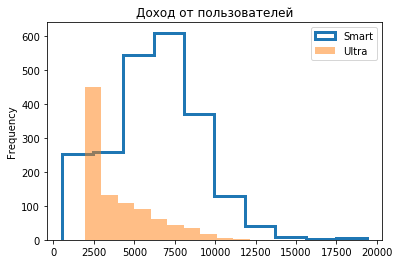

In [38]:
ax = (data_smart
     .plot(
         kind='hist',
         y='income',
         histtype='step',
         linewidth=3,
         legend=True,
         label='Smart'))

(data_ultra.plot(kind='hist', 
                 y='income',
                 ax=ax,
                 alpha=0.5,
                 legend=True,
                 label='Ultra',
                 title='Доход от пользователей'));

In [39]:
data.pivot_table(index='tariff',
                 values='income',
                 aggfunc=['mean','var', 'std'])

,mean,var,std
,income,income,income
tariff,,,
smart,6247.616284,8.388051e+06,2896.213239
ultra,3847.318612,4.673811e+06,2161.899911


Перед тем как делать проверку гипотез я бы сделал выборку где отсек в data_smart значения больше 10000. Но сделаю проверку и по такой выборке

In [40]:
data_smart_fill = data_smart.query('income < 10000')
data_ultra_fill = data_ultra.query('income < 10000')

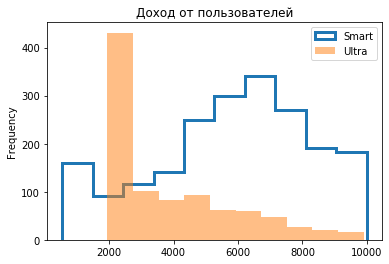

In [41]:
ax = (data_smart_fill
     .plot(
         kind='hist',
         y='income',
         histtype='step',
         linewidth=3,
         legend=True,
         label='Smart'))

(data_ultra_fill.plot(kind='hist', 
                 y='income',
                 ax=ax,
                 alpha=0.5,
                 legend=True,
                 label='Ultra',
                 title='Доход от пользователей'));

In [42]:
data_fill = data.query('income < 10000')

data_fill.pivot_table(index='tariff',
                 values='income',
                 aggfunc=['mean','var', 'std'])

,mean,var,std
,income,income,income
tariff,,,
smart,5777.347358,6.130618e+06,2476.008537
ultra,3787.698834,4.286117e+06,2070.293964


## Шаг. Проверьте гипотезы

Сформулируем нулевую гипотезу *средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются*. В качестве альтернативной гипотезы я двухстороннюю гипотезу: *Средняя выручка пользователей тарифов "Ультра" и "Смарт" равна*. Будем сравнивать по t-тесту двух независимых выборок. Так же установим, что дисперсии различаются.

In [43]:
alpha = .05

results = st.ttest_ind(
    data_smart['income'], 
    data_ultra['income'],
    equal_var=False
    )

print('p-значение:', results.pvalue ) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.705541542357394e-129
Отвергаем нулевую гипотезу


In [44]:
alpha = .05

results = st.ttest_ind(
    data_smart_fill['income'], 
    data_ultra_fill['income'],
    equal_var=False
    )

print('p-значение:', results.pvalue ) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.818091772178626e-104
Отвергаем нулевую гипотезу


Что по всей выборке, что по обрезанной видно, что нулевая гипотеза отвергается, значит не смотря на разное среднее значение выручки тарифов по таблице t-тест нам показывает, что тарифы по среднему значению не различаются.

Перед формулированием вторых гипотез сделаем выборки.

In [45]:
data_msc = data.query('city == "Москва"')
data_other = data.query('city != "Москва"')

Сформулируем нулевую гипотезу : *средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов*. Тогда альтернативная гипотеза будет *средняя выручка пользователей из Москвы равна выручке пользователей из других регионов*.

In [46]:
alpha = .05

results = st.ttest_ind(
    data_msc['income'], 
    data_other['income'],
    equal_var=False
    )

print('p-значение:', results.pvalue ) 

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.207311045729509
Не получилось отвергнуть нулевую гипотезу


Тут же у нас получается, что средняя выручка из Москвы всё таки различается от средней выручки из других регионов.

In [64]:
df_month = data_fill.pivot_table(index='month',
                 values='income',
                 aggfunc=['mean','var', 'std'])

df_month

,mean,var,std
,income,income,income
month,,,
1,2526.162791,4.944335e+06,2223.586013
2,3501.469136,5.369964e+06,2317.318327
3,4748.768519,6.865456e+06,2620.201450
4,4339.969325,6.291273e+06,2508.241016
5,5005.757732,6.122010e+06,2474.269492
6,4931.489270,6.132545e+06,2476.397531
7,5088.551471,6.588261e+06,2566.760742
8,5321.140625,6.520971e+06,2553.619111


## Шаг. Напишите общий вывод

- как можно объяснить разницу дисперсий при оценке услуг? В моем понимании разница в дисперсии объясняется в том, что в тарифе смарт меньший порог бесплатных услуг, по сравнению с тарифом ультра, и поэтому большинство людей выходит за рамки бесплатной части тарифа, что тем самым делает более сильную дисперсию.
- как влияет разница кол-ва пользователей на результаты? Мне кажется с большим количеством пользователей можно было бы увидеть более плавное расспределение данных.
- какие можно обнаружить зависимости при оценке усредненных по месяцам показателей? Я вижу только одну зависимость, что в первые два месяца года выручка от тарифов меньше, мне кажется это связанно с тем что люди могу отдыхать после нового года и меньше всего использовать связь
- какой тариф по твоему мнению лучше и почему? С точки зрения дохода то тариф смарт конечно лучше, потому что бесплатная часть тарифа не такая большая, и можно заработать огромную сумму на доп услугах. Но как покупать я бы выбрал тариф ультра, так как он более выгоден для пользователей, так как они в среднем используют больше интернета, связи, но не смс.